In [56]:
import tensorflow as tf

from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
tfds.disable_progress_bar()


In [127]:
from pathlib import Path
from nltk import sent_tokenize, word_tokenize
from gensim.models import Word2Vec
shakespeare_file = Path(keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'))
import numpy as np
import os



In [10]:
text = shakespeare_file.read_text()

data = []
text.replace("\n", " ")
for sent in sent_tokenize(text):
    temp = []
    for word in word_tokenize(sent):
        temp.append(word.lower())
    data.append(temp)

In [26]:
# model1 = Word2Vec(data, min_count = 1, size = 100, window = 5)

c:\users\matt\.virtualenvs\shakespeare-yiqms4mk\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `accuracy` (Method will be removed in 4.0.0, use self.wv.evaluate_word_analogies() instead).
  


TypeError: accuracy() missing 1 required positional argument: 'questions'

In [18]:
model = Word2Vec.load('shakespeare-word2vec')

array([ 0.5057565 , -0.053016  ,  0.45338652, -0.10344332,  0.43204176,
       -1.2580359 ,  0.9342382 , -1.208915  ,  0.56480867,  0.3880566 ,
        1.012012  ,  0.1022644 ,  1.0499395 ,  0.6648435 ,  0.31496313,
       -0.04502418, -0.9529445 ,  0.6657609 ,  0.38900307, -0.9419692 ,
       -1.7142498 , -1.1354386 , -1.7685347 , -0.12926774, -0.18009426,
       -0.439447  , -0.28933892,  0.9668946 ,  1.2762942 ,  1.0544156 ,
       -0.69818157, -0.22766027, -0.40222988, -1.0733414 , -1.4766911 ,
        1.321728  , -0.39245874, -0.3083035 ,  0.30148154, -0.03773219,
       -0.09181303, -0.01660844,  0.614552  ,  0.3559114 , -1.173487  ,
        1.0077215 , -0.49851865,  0.6766645 , -0.4499968 ,  0.15344678,
       -0.8369256 , -1.0871986 ,  0.28385162, -1.7437805 ,  0.08514836,
       -0.4511626 ,  0.01649415, -1.0365864 , -0.5145726 , -0.43864638,
        0.66018796, -0.2440788 , -0.81783783, -1.1765603 , -0.78410137,
       -0.6411589 ,  0.08166179,  0.1429279 , -0.9634847 , -0.36

In [31]:
vocab_size = len(model.wv.vocab)


In [90]:
word_vectors = []
for sent in data:
    temp = []
    for word in sent:
        word_vectors.append(model.wv[word])

In [91]:
database = tf.data.Dataset.from_tensor_slices(word_vectors)

In [104]:
def word_tensor_to_word(t):
    return model.wv.most_similar(positive=[t.numpy()], topn=1)[0][0]


In [106]:
for i in database.take(5):
    print(word_tensor_to_word(i))

first
citizen
:
before
we


In [187]:
seq_length = 20
examples_per_epoch = len(word_vectors)//(seq_length+1)

In [188]:
sequences = database.batch(seq_length+1, drop_remainder=True)
for vectors in sequences.take(5):
    print(' '.join([word_tensor_to_word(vec) for vec in vectors]))
    

first citizen : before we proceed any further , hear me speak . all : speak , speak . first citizen
: you are all resolved rather to die than to famish ? all : resolved . resolved . first citizen :
first , you know caius marcius is chief enemy to the people . all : we know't , we know't .
first citizen : let us kill him , and we 'll have corn at our own price . is't a verdict
? all : no more talking o n't ; let it be done : away , away ! second citizen :


In [189]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [190]:
# Batch size
BATCH_SIZE = 128

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((128, 20, 100), (128, 20, 100)), types: (tf.float32, tf.float32)>

In [191]:

def build_model(embedding_dim, rnn_units, batch_size):
  tf_model = tf.keras.Sequential([
    keras.layers.LSTM(rnn_units,
                        batch_input_shape=[batch_size, None, embedding_dim],
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    keras.layers.Dense(embedding_dim)
  ])
  return tf_model

tf_model = build_model(100, 1024, BATCH_SIZE)

In [117]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = tf_model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")
  

(64, 20, 100) # (batch_size, sequence_length, vocab_size)


In [192]:
tf_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (128, None, 1024)         4608000   
_________________________________________________________________
dense_20 (Dense)             (128, None, 100)          102500    
Total params: 4,710,500
Trainable params: 4,710,500
Non-trainable params: 0
_________________________________________________________________


In [193]:


tf_model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [172]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints_b_128'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [194]:
EPOCHS=300

history = tf_model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/300
94/94 [==============================] - 5s 52ms/step - loss: 0.0835
Epoch 2/300
94/94 [==============================] - 3s 29ms/step - loss: 0.0758
Epoch 3/300
94/94 [==============================] - 3s 30ms/step - loss: 0.0741
Epoch 4/300
94/94 [==============================] - 3s 29ms/step - loss: 0.0726
Epoch 5/300
94/94 [==============================] - 3s 30ms/step - loss: 0.0716
Epoch 6/300
94/94 [==============================] - 3s 28ms/step - loss: 0.0707
Epoch 7/300
94/94 [==============================] - 3s 28ms/step - loss: 0.0702
Epoch 8/300
94/94 [==============================] - 3s 29ms/step - loss: 0.0698
Epoch 9/300
94/94 [==============================] - 3s 27ms/step - loss: 0.0696
Epoch 10/300
94/94 [==============================] - 3s 27ms/step - loss: 0.0692
Epoch 11/300
94/94 [==============================] - 2s 26ms/step - loss: 0.0691
Epoch 12/300
94/94 [==============================] - 3s 28ms/step - loss: 0.0687
Epoch 13/300
94/94 [=====

In [181]:
history_lstm = np.array([])
# history_lstm = history.history.copy()

{'loss': [0.08504305248881908, 0.07518246429080659, 0.0737164077606607, 0.07226255425113312, 0.07132877250935168, 0.07116243893161733, 0.07081436674962653, 0.07042961940169334, 0.06999212590620872, 0.06977202418319722, 0.06954258006620914, 0.06928474670077892, 0.06908678818256297, 0.06903369796085865, 0.06879700688605613, 0.06857943915306254, 0.06842046595634298, 0.06831492911627952, 0.06817425525885948, 0.06796276902264738, 0.06783613721106915, 0.06777650633073867, 0.06762957517453964, 0.06758401669720386, 0.06739376081114119, 0.06717959585342001, 0.06706731742683877, 0.06689314076558073, 0.06669509418784304, 0.06660204253932263, 0.06637593414238159, 0.06625754893460173, 0.06609557806811434, 0.06571167263578861, 0.06570759161989739, 0.06513975921304936, 0.0648422343458267, 0.06434097557150303, 0.06384611537957445, 0.0630645603734128, 0.06222171554381543, 0.06138615373601305, 0.060251009075882586, 0.058966931510478895, 0.057711754747210665, 0.05630008190711762, 0.055071469634137254, 0.

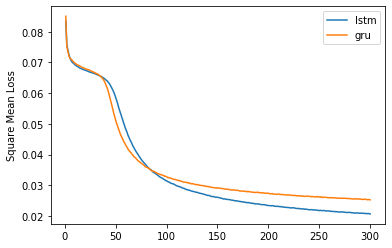

In [199]:
import matplotlib.pyplot as plt
plt.clf()
plt.plot(range(1,301), history.history['loss'], label='lstm')
plt.plot(range(1,301), history_lstm['loss'], label='gru')
plt.ylabel("Square Mean Loss")
plt.legend()
plt.savefig('losses.jpg')
plt.show()


In [200]:
prediction_model = build_model(100, 1024, 1)

prediction_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

prediction_model.build(tf.TensorShape([1, None]))

In [202]:
def generate(words):
    input_eval = [model.wv[word] for word in words]
    input_eval = tf.expand_dims(input_eval, 0)

    text_generated = []
    prediction_model.reset_states()
    
    for i in range(20):
        predictions = prediction_model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        
        new_word_tensor = predictions[-1]
        input_eval = tf.expand_dims([new_word_tensor], 0)
        
        text_generated.append(word_tensor_to_word(new_word_tensor))
    return text_generated

In [206]:
text = generate(['i', 'have', 'been'])

print(text)

['hard', 'remembrance', 'hath', 'what', ':', 'doubt', 'been', 'been', 'did', 'your', 'accept', 'up', 'yonder', 'pluck', 'one', 'woe', 'becomes', 'aufidius', ':', 'well']
